## Step 0: Setup & Imports

In [17]:

# Zaroori libraries import kar lete hain..
# idea yeh hai ke minimal cheezen use hon jo offline chal jayein
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons   # toy dataset banane ke liye
from sklearn.model_selection import train_test_split  # split ke liye

# yeh seed set kar rahe hain taake results repeatable rahen
np.random.seed(42)


## Step 1: Activation Functions & Derivatives + Loss

In [18]:

# activation functions + unki derivatives
# yeh wale functions model ko non-linearity dete hain, warna sirf linear hota

def sigmoid(z):
    # yeh output ko 0..1 range me le aata hai
    return 1.0 / (1.0 + np.exp(-z))

def dsigmoid(z):
    # sigmoid ki derivative: s * (1 - s)
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    # relu: zero se neeche sab 0, warna same value
    return np.maximum(0, z)

def drelu(z):
    # relu ki derivative: z>0 ho to 1, warna 0
    return (z > 0).astype(float)

def tanh_(z):
    # tanh: -1 se 1 ke darmiyan compress karta hai
    return np.tanh(z)

def dtanh_(z):
    # tanh ki derivative: 1 - tanh(z)^2
    t = np.tanh(z)
    return 1 - t**2

# simple mapping taake string name se function mil jaye
ACT_FUNCS = {
    "sigmoid": (sigmoid, dsigmoid),
    "relu": (relu, drelu),
    "tanh": (tanh_, dtanh_),
}

def binary_cross_entropy(y_hat, y, eps=1e-12):
    # eps use kar rahe hain taake log(0) se bach sakein
    y_hat_c = np.clip(y_hat, eps, 1 - eps)
    m = y.shape[1]  # sample quantity (column-wise data)
    loss = -(1.0/m) * np.sum(y * np.log(y_hat_c) + (1 - y) * np.log(1 - y_hat_c))
    return loss



## Step 2: "DeepNeuralNetwork" Class
- He init for ReLU, Xavier for others  
- Forward caches (Z, A_prev, A, W, b)  
- Backprop layer-by-layer  
- Gradient Descent updates  
- Train loop + Predict


In [19]:

class DeepNeuralNetwork:
    # note: activation_funcs like ["relu","relu","sigmoid"]
    def __init__(self, layer_dims, activation_funcs):
        # layer_dims e.g., [2, 20, 10, 1]
        # activation_funcs length == len(layer_dims) - 1
        self.layer_dims = layer_dims
        self.activation_names = activation_funcs
        assert len(activation_funcs) == len(layer_dims) - 1, "activation_funcs ki length layer_dims-1 honi chahiye"

        self.parameters = {}
        self.L = len(layer_dims) - 1  # weighted layers quantity
        self._initialize_parameters()

    def _initialize_parameters(self):
        # yahan He init ReLU ke liye aur Xavier baaqiyon ke liye use kar rahe hain
        for l in range(1, self.L + 1):
            fan_in = self.layer_dims[l-1]
            fan_out = self.layer_dims[l]
            act = self.activation_names[l-1].lower()

            if act == "relu":
                # He initialization
                W = np.random.randn(fan_out, fan_in) * np.sqrt(2.0 / fan_in)
            else:
                # Xavier (Glorot) initialization
                W = np.random.randn(fan_out, fan_in) * np.sqrt(1.0 / fan_in)

            b = np.zeros((fan_out, 1))
            self.parameters[f"W{l}"] = W
            self.parameters[f"b{l}"] = b
        # chhote random weights symmetry break karte hain, learning start hoti hai

    def forward_pass(self, X):
        # yeh function data ko layer-by-layer aage bhejta hai
        # har layer ka cache store karte jaenge
        caches = []
        A = X  # start me A = X
        for l in range(1, self.L + 1):
            W = self.parameters[f"W{l}"]
            b = self.parameters[f"b{l}"]
            A_prev = A  # yeh previous activations hain
            Z = np.dot(W, A_prev) + b
            act_name = self.activation_names[l-1].lower()
            act_fn = ACT_FUNCS[act_name][0]
            A = act_fn(Z)
            caches.append({
                "Z": Z, "A_prev": A_prev, "A": A, "W": W, "b": b, "activation": act_name
            })
        return A, caches

    def backward_pass(self, X, y, caches):
        # backprop: output se peeche ki taraf gradients nikalte hain
        grads = {}
        m = X.shape[1]
        AL = caches[-1]["A"]

        # BCE dL/dAL
        eps = 1e-12
        ALc = np.clip(AL, eps, 1 - eps)
        dAL = -((y / ALc) - ((1 - y) / (1 - ALc)))

        dA = dAL

        for l in reversed(range(1, self.L + 1)):
            cache = caches[l-1]
            Z = cache["Z"]
            A_prev = cache["A_prev"]
            W = self.parameters[f"W{l}"]
            act_name = cache["activation"]
            act_deriv = ACT_FUNCS[act_name][1]

            # dZ = dA * g'(Z)
            dZ = dA * act_deriv(Z)
            dW = (1.0/m) * np.dot(dZ, A_prev.T)                 # shape: (fan_out, fan_in)
            db = (1.0/m) * np.sum(dZ, axis=1, keepdims=True)    # shape: (fan_out, 1)
            dA = np.dot(W.T, dZ)                                 # propagate back

            grads[f"dW{l}"] = dW
            grads[f"db{l}"] = db

        return grads

    def update_parameters(self, grads, learning_rate):
        # simple gradient descent update
        for l in range(1, self.L + 1):
            self.parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
            self.parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]

    def train(self, X, y, epochs=5000, learning_rate=0.1, print_loss=True, print_every=500):
        # training loop: forward -> loss -> backward -> update
        losses = []
        for epoch in range(1, epochs+1):
            AL, caches = self.forward_pass(X)
            loss = binary_cross_entropy(AL, y)
            grads = self.backward_pass(X, y, caches)
            self.update_parameters(grads, learning_rate)

            losses.append(loss)
            if print_loss and (epoch % print_every == 0 or epoch == 1):
                print(f"Epoch {epoch}/{epochs} | Loss: {loss:.4f}")
        return losses

    def predict(self, X, threshold=0.5):
        # forward chala ke prob nikalte hain, phir threshold laga ke 0/1 banate hain
        AL, _ = self.forward_pass(X)
        return (AL >= threshold).astype(int)


## Step 3: Helper Visualization Functions

In [20]:

# Plotting helpers
def plot_dataset(X, y):
    # simple scatter taake feel aaye ke data kaisa hai
    plt.figure()
    plt.scatter(X[0, :], X[1, :], c=y.flatten(), alpha=0.8)
    plt.title("Synthetic 2D Dataset (moons)")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

def plot_loss(losses):
    # training loss ka trend dekhne ke liye
    plt.figure()
    plt.plot(losses)
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy Loss")
    plt.show()

def plot_decision_boundary(model, X, y, h=0.02):
    # decision boundary dikhane ke liye mesh grid bana lete hain
    x_min, x_max = X[0, :].min() - 1.0, X[0, :].max() + 1.0
    y_min, y_max = X[1, :].min() - 1.0, X[1, :].max() + 1.0
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid = np.c_[xx.ravel(), yy.ravel()].T  # shape: (2, N)
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[0, :], X[1, :], c=y.flatten(), alpha=0.8)
    plt.title("Decision Boundary")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()


## Step 4: Generate Dataset (Moons) & Visualize

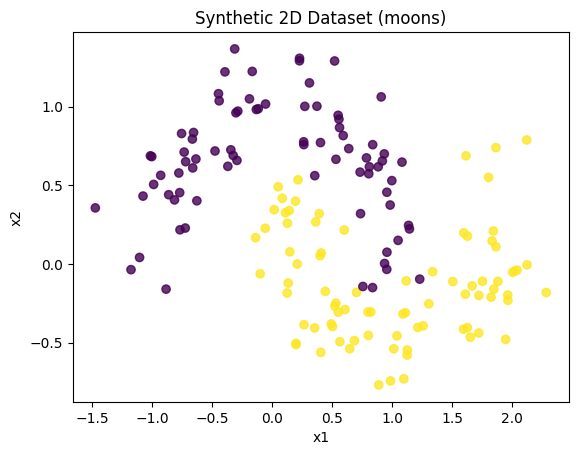

In [21]:

# Dataset banate hain (non-linear moons)
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)

# shape ko (features, samples) me convert karte hain
X = X.T                  # (2, 200)
y = y.reshape(1, -1)     # (1, 200)

# train/test split bhi rakh lete hain, taake generalization ka idea mile
X_train, X_test, y_train, y_test = train_test_split(X.T, y.T, test_size=0.2, random_state=42)
X_train, y_train = X_train.T, y_train.T
X_test, y_test = X_test.T, y_test.T

# data visualize
plot_dataset(X_train, y_train)


## Step 5: Build & Train the DFNN

Epoch 1/4000 | Loss: 0.6765
Epoch 500/4000 | Loss: 0.2276
Epoch 1000/4000 | Loss: 0.1111
Epoch 1500/4000 | Loss: 0.0627
Epoch 2000/4000 | Loss: 0.0453
Epoch 2500/4000 | Loss: 0.0384
Epoch 3000/4000 | Loss: 0.0340
Epoch 3500/4000 | Loss: 0.0310
Epoch 4000/4000 | Loss: 0.0287


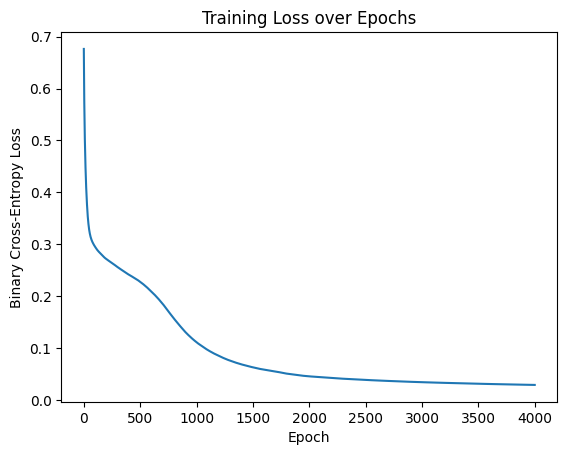

In [22]:

# Model architecture select karte hain
layer_dims = [2, 20, 10, 1]
activation_funcs = ["relu", "relu", "sigmoid"]

model = DeepNeuralNetwork(layer_dims, activation_funcs)

# train karte hain..
losses = model.train(X_train, y_train, epochs=4000, learning_rate=0.1, print_loss=True, print_every=500)

# loss curve dekh lete hain
plot_loss(losses)


## Step 6: Decision Boundary Visualization

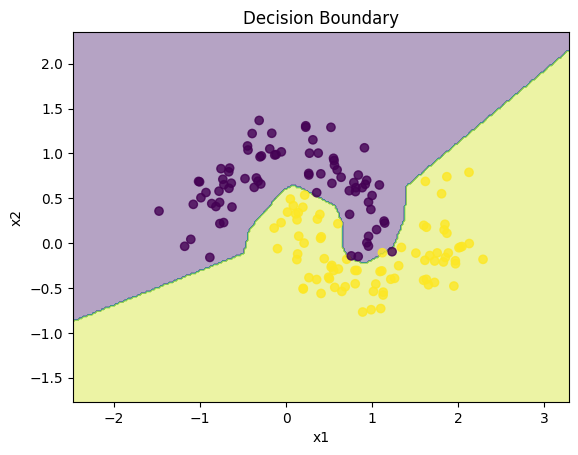

In [23]:

# Decision boundary plot
plot_decision_boundary(model, X_train, y_train)


## Step 7: Evaluation (Accuracy)

In [24]:

# Training/test accuracy nikalte hain..
y_pred_train = model.predict(X_train)
train_acc = (y_pred_train == y_train).mean() * 100.0
print(f"Training Accuracy: {train_acc:.2f}%")

y_pred_test = model.predict(X_test)
test_acc = (y_pred_test == y_test).mean() * 100.0
print(f"Test Accuracy: {test_acc:.2f}%")


Training Accuracy: 98.75%
Test Accuracy: 92.50%



## Step 8: Discussion (Brief)
- **Loss curve** usually neeche jati hai, jo learning ko indicate karta hai.  
- **Decision boundary** 2 moon shapes ko wrap karni chahiye; ReLU layers wali architecture nonlinear regions carve kar sakti hai.  
- **Accuracy** train pr zyada hoti hai (aksar 90%+). Test thori kam ho sakti hai noise/variance ki wajah se.  
- **Tips:** LR agar zyada ho to loss oscillate karega, thora kam kar dein ya epochs barha dein. He-init ReLU ke liye helpful hai, Xavier sigmoid/tanh ke liye safe rehta hai.
